
# Welcome to Safran TP 1

<br>
<div style="text-align: justify"> 
Every day, more than 80,000 commercial flights take place around the world, operated by hundreds of airlines. For all aircraft take-off weight exceeding 27 tons, a regulatory constraint requires companies to systematically record and analyse all flight data, for the purpose of improving the safety of flights. Flight Data Monitoring strives to detect and prioritize deviations from standards set by the aircraft manufacturers, the authorities of civil aviation in the country, or even companies themselves. Such deviations, called events, are used to populate a database that enables companies to identify and monitor the risks inherent to these operations.
</div>
<br>
<div style="text-align: justify"> 
This notebook is designed to let you manipulate real aeronautical data, provided by the Safran Group. It is divided in two parts: the first part deals with the processing of raw data, you will be asked to visualize the data, understand what variables require processing and perform the processing for some of these variables. The second part deals with actual data analysis, and covers some interesting problems. We hope to give you some insights of the data scientist job and give you interesting and challenging questions.
</div>

<h1><div class="label label-success">Part 1: Data processing</div></h1>

## Loading the data

Load the **raw** data into the structure proposed below (the schema is given to you), using the code provided. The definition of the variables available is given here:

| var | description |
|:-----:|:-------------:|
| TIME   | elapsed seconds|
| LATP_1 | Latitude (°)|
| LONP_1 | Longitude (°)|
| RALT1 | Radio Altitude, sensor 1 (feet)|
| RALT2 | Radio Altitude, sensor 2 (feet)|
| RALT3 | Radio Altitude, sensor 3 (feet)|
| ALT_STD | Relative Altitude (feet)|
| HEAD | head (°)|
| PITCH | pitch (°)|
| ROLL | roll (°)|
| IAS | Indicated Air Speed (m/s)|
| N11 | speed N1 of the first engine (% of tr/min)|
| N21 | speed N2 of the first engine (% of tr/min)|
| N12 | speed N1 of the second engine (% of tr/min)|
| N22 | speed N2 of the second engine (% of tr/min)|
| AIR_GROUND | boolean, 0: ground, 1: air|

The sample rate is 1 Hz. You will be provided with `780` flight records. Each is a full record of a flight starting at the beginning of the taxi out phase and terminating at the end of the taxi in phase. Please be aware that due to side effects the very beginning of the record may be faulty. This is something to keep in mind when we will analyse the data.

** Note ** : `TIME` represents the elapsed seconds from today midnight. You are not provided with an absolute time variable that would tell you the date and hour of the flights.

You will need some expertise about the signification of the variables. Latitude and longitude are quite straightforward. Head, Pitch and Roll are standards orientation angles, check this [image](https://i.stack.imgur.com/65EKz.png) to be sure. RALT\* are coming from three different radio altimeters, they measure the same thing but have a lot of missing values and are valid only under a threshold altitude (around 5000 feet). Alt_std is the altitude measured from the pressure (it basically comes from a barometer), it is way less accurate that a radio altimeter but provides values for all altitudes. N1\* and N2\* are the rotational speeds of the engine sections expressed as a percentage of a nominal value. Some good links to check out to go deeper: 
- [about phases of flight](http://www.fp7-restarts.eu/index.php/home/root/state-of-the-art/objectives/2012-02-15-11-58-37/71-book-video/parti-principles-of-flight/126-4-phases-of-a-flight)
- [pitch-roll-head](https://i.stack.imgur.com/65EKz.png)
- [about N\*\* variables I](http://aviation.stackexchange.com/questions/14690/what-are-n1-and-n2)
- [about N\*\* variables II](https://www.quora.com/Whats-N1-N2-in-aviation-And-how-is-the-value-of-100-N1-N2-determined)
- [how altimeters work](http://www.explainthatstuff.com/how-altimeters-work.html)
- [about runway naming](https://en.wikipedia.org/wiki/Runway#Naming)

In [5]:
BASE_DIR = "/mnt/datasets/SAFRAN/data/"

from os import listdir
from os.path import isfile, join

import glob

import matplotlib as mpl
mpl.rcParams["axes.grid"] = True
import matplotlib.pylab as plt
%matplotlib inline

import numpy as np
import pandas as pd
pd.options.display.max_columns = 50

from datetime import datetime

# from haversine import haversine

def load_data_from_directory(DATA_PATH, num_flights):
    files_list = glob.glob(join(DATA_PATH, "*pkl"))
    print("There are %d files in total" % len(files_list))
    files_list = files_list[:num_flights]
    print("We process %d files" % num_flights)
    dfs = []
    p = 0
    for idx, f in enumerate(files_list):
        if idx % int(len(files_list)/10) == 0:
            print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")
            p += 1
        dfs.append(pd.read_pickle(f))
    print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")
    return dfs

from IPython.core.display import HTML
#css = open('style-table.css').read()
#HTML('<style>{}</style>'.format(css))

<div class="label label-primary">Execute the cell below to load the data for part 1</div>

In [ ]:
num_flights = 780
flights1 = load_data_from_directory(BASE_DIR + "part1/flights", num_flights)
for f in flights1:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)

The data is loaded with pandas. Please take a look at the [pandas cheat sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) if you have any doubt. You are provided with 780 dataframes, each of them represents the records of the variables defined above during a whole flight.

`flights1` is a list where each item is a dataframe storing the data of one flight. There is no particular ordering in this list. All the flights depart from the same airport and arrive at the same airport. These airports are hidden to you and you will soon understand how.

For example `flights1[0]` is a dataframe, representing one flight.

In [ ]:
flights1[0].head(20)

You can select a column by indexing by its name.

In [ ]:
flights1[0]["PITCH"].describe()

Use `iloc[]` to select by line number, either the whole dataframe to obtain all the variables or an individual series.

In [ ]:
flights1[0].iloc[50:60]

In [ ]:
flights1[0]["PITCH"].iloc[50:60]

## Visualization

To perform monitoring of flights, it is necessary to clean up the data. To start, it is important to visualize the data that is available, in order to understand better their properties and the problems associated with them (noise, statistical characteristics, <del>ladders</del>, features and other values).

<div class="alert alert-info">
<h3><div class="label label-default">Question 1</div>  <div class="label label-info">Visualize all the variables</div></h3>
<br>
For an arbitrary flight, for example <code>flights1[0]</code>, visualize all the variables. Would you rather use plot or scatter? Interpolate the data or not interpolate? Think about NaN values and how they are treated when we plot a series. Comment.
</div>

In [ ]:
# your code goes here ...

Your comment here:

...

If it is interesting to see the variables for a given flight, it is more informative to view the set of values for all flights in order to understand what are the significant/normal values and what are those which are abnormal.

<div class="alert alert-info">
<h3><div class="label label-default">Question 2</div>  <div class="label label-info">Visualize N21 variable for all flights</div></h3>
<br>
For the <code>N21</code> variable, for example, display all of the flights on the same figure. Use alpha parameter to add transparency to your plot. Is there any pattern? Comment the variabilities you observe.
</div>

In [ ]:
# your code goes here ...

Your comment here:

...

Some variables must be analyzed together, such as latitude and longitude, otherwise the visualization information will be incomplete, we could be missing something.

<div class="alert alert-info">
<h3><div class="label label-default">Question 3</div>  <div class="label label-info">Visualize latitude against longitude for all flights</div></h3>
<br>
Display the trajectories (<code>LONP_1</code>, <code>LATP_1</code>) of the first 20 flights, that is <code>flights1[:20]</code>. What do you see? Keep in mind that the data during the beginning of the recording may be abnormal. What insight do you lose when you plot <code>LONP_1</code> against <code>LATP_1</code> ?
</div>

In [ ]:
# your code goes here ...

Your comment here:

...

Keep in mind that our goal is to understand the nature and the inherent problems of our data, and its features. Proceed with the visual analysis of the data, looking at different features.

<div class="alert alert-info">
<h3><div class="label label-default">Question 4</div>  <div class="label label-info">Recap variables that require pre-processing</div></h3>
<br>
Based on your observations as for now, what are the variables requiring processing? For each of these variables, specify the necessary pre-processing required prior to perform data analysis.
</div>

Your answer here:

...

It is important to undestand the links between variables, to understand how a system works.

<div class="alert alert-info">
<h3><div class="label label-default">[NEW] Question </div>  <div class="label label-info">Correlation between variables</div></h3>
<br>
 Compute the correlation of each normalized variables with any others for one flight.
Compute delay and max value for each pair of variables.
What happens if you do not normalize ?
What are the most correlated variables or group of variables ?
Can you comment about the delay between variables ?
</div>

In [ ]:
from scipy import signal
def correlation(x,y):
    all_correlations = signal.interpolate(x,y)
    maximum_correlation = np.max(all_correlations)
    delay = np.argmax(correlations)-x.shape[0]+1
    return maximum_correlation, delay   


In [ ]:
# your code goes here ...

Your comment here:

...

## Pre-processing

Data pre-processing is essential, in order to separate the errors due to measurement from "normal" data variability, which is representative of the phenomenon that interests us.

<div class="alert alert-info">
<h3><div class="label label-default">Question 5</div>  <div class="label label-info">Smooth and filter out abnormal data in trajectories (LATP_1 and LONP_1)</div></h3>
<br>
Filter the flight trajectories (<code>LATP_1</code> and <code>LONP_1</code> variables). You can focus on the first 20 flights, that is <code>flights1[:20]</code>. Display the trajectories before and after smoothing.
</div>

```python
# this is a template code, fill in the blanks, or use your own code

# Only work with the first few flights
fs = flights1[:20]

# Set up the figure to plot the trajectories before (ax0) and after smoothing (ax1)
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(15)
ax0, ax1 = axarr

for f in fs:
    f["LATP_1_C"] = f.LATP_1.rolling(window=...).... # FILL IN THE BLANKS
    f["LONP_1_C"] = f.LONP_1.rolling(window=...).... # FILL IN THE BLANKS

for f in fs:
    f.plot(kind="scatter", x="LATP_1", y="LONP_1", s=1, ax=ax0) # plot raw trajectory
    f.plot(kind="scatter", x="LATP_1_C", y="LONP_1_C", s=1, ax=ax1) # plot smoothed trajectory
    
    
fig.tight_layout()

```

<div class="alert alert-info">
<h3><div class="label label-default">Question 6</div>  <div class="label label-info">Pre-process HEAD, get rid off discontinuities</div></h3>
<br>
Angles are special variables because they "cycle" over their range of values. The <code>HEAD</code> variable shows artificial discontinuities: your goal is to eliminate (filter out) such discontinuities. The angle may no longer be between 0 and 360 degrees after the transformation but it will come very handy for some analysis later. Display the data before and after transformation. You can focus on one flight, for example <code>flights1[0]</code>.
</div>

In [ ]:
# your code goes here ...

Your comment here:

...

<div class="alert alert-info">
<h3><div class="label label-default">[NEW] Question</div>  <div class="label label-info">All data on the same time base</div></h3>
<br>When we make an analysis, it is important to have the maximum of information. However, for any flight, you can see that there is three RALT (<code>RALT1</code>, <code>RALT2</code>, <code>RALT3</code>). They are not at the same sampling rate.
Use interpolation on one flight, for example <code>flights1[0]</code>,to have them at the same sampling rate of 1Hz. Then, merge your results. Can you comment on the method you used ?
</div>

In [ ]:
from scipy import interpolate
# your code goes here ...

Your comment here:

...


<h1><div class="label label-success">Part 2: Analysis</div></h1>

We now turn to the data analysis task. In this part, we will use a **clean** dataset, which has been prepared for you; nevertheless, the functions you developed in the first part of the notebook can still be used to visualize and inspect the new data. Next, we display the schema of the new dataset you will use:

| var | description |
|:-----:|:-------------:|
| TIME   |elapsed seconds|
| **LATP_C** | **Latitude (°), Corrected**|
| **LONP_C** | **Longitude (°), Corrected**|
| **RALT_F** | **Radio Altitude (feet), Fusioned**|
| **ALT_STD_C** | **Relative Altitude (feet), Corrected**|
| **HEAD_C** | **head (°), Corrected**|
| **HEAD_TRUE** | **head (°), without discontinuities**|
| **PITCH_C** | **pitch (°), Corrected**|
| **ROLL_C** | **roll (°), Corrected**|
| **IAS_C** | **Indicated Air Speed (m/s), Corrected**|
| N11 | speed N1 of the first engine (% of tr/min)|
| N21 | speed N2 of the first engine (% of tr/min)|
| N12 | speed N1 of the second engine (% of tr/min)|
| N22 | speed N2 of the second engine (% of tr/min)|
| AIR_GROUND | status in the air (Boolean)|

<div class="label label-primary">Execute the cell below to load the data for part 2</div>

In [11]:
num_flights = 780
flights2 = load_data_from_directory(BASE_DIR + "part2/flights/", num_flights)
for f in flights2:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)

There are 780 files in total
We process 780 files


In this part, we will try to modelize a time series with simple models. In particular, we will look at the landing, and the N1 variable.

<div class="label label-primary">
 First, look at the variables for the flight 0, by executing the following code.
</div>

In [ ]:
plt.plot(flights2[0]['N11'], 'b')
index_start = 4500
tomodel = flights2[0]['N11'][index_start:index_start+1600] 
topredict = flights2[0]['N11'][index_start+1600:index_start+3600] 
plt.plot(tomodel, 'g')
plt.plot(topredict, 'r')


<div class="alert alert-info">
<h3><div class="label label-default">[NEW] Question</div>  <div class="label label-info">Modelization of time series</div></h3>
<br>
Is it stationary ? The augmented Dickey-Fuller test is a popular test to test the null hypothesis that a time series sample is non-stationary. Use this test to confirm what you observed.
</div>

In [ ]:
import scipy.stats.stats as stats
from statsmodels.tsa.stattools import adfuller
# your code goes here




DFtest_brut = ...
print('Augmented D-F test before detrending:')
print('p-value = ' + str(DFtest_brut))

Your comment goes here ...

<div class="alert alert-info">
<h3><div class="label label-default">[NEW] Question</div>  <div class="label label-info">Modelization of time series</div></h3>
<br>
We may want to detrend the time serie. Fit a polynom or order 3 to the sequence <code>tomodel</code>, remove the trend and look at the Dickey-Fuller test again. Should you have used an higher degree polynomial? What would be the issue of a high degree polynomial when trying to do prediction of future sample?

</div>

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
# Your code goes here

DFtest_corrected
print('Augmented D-F test after detrending:')
print('p-value = ' + str(DFtest_corrected))

Your comment goes here...

<div class="alert alert-info">
<h3><div class="label label-default">[NEW] Question</div>  <div class="label label-info">Prediction using polynomial</div></h3>
<br>
We want to predict what will be our next N11 in the next time steps. Use the polynom to predict the end of <code>tomodel</code>. Compare to <code>topredict</code>. What can you say ? What could you do to improve your prediction ?
</div>


In [ ]:
# Your code goes here

Your comment goes here...

We will now see if we can model the time series using auto-regressive / moving-average models.
The **ARIMA** technique (Auto-Regressive Integrated Moving Average) allows modeling and forecasting of time series. The parameters of an ARIMA model are often noted (p,d,q) where:
- p is the number of auto-regressive terms (AR), e.g. if p=3, x(t) will be determined from x(t-1), x(t-2) and x(t-3)
- d is the number of differences to take before obtaining a stationary time series
- q is the number of moving average (MA) terms.

Autocorrelation (ACF) and partial autocorrelation (PACF) plots are a usefull tool to identify the values for *p* and *q*. The autocorrelation describes the correlation of observations with observations at previous time steps (or lags).
Partial autocorrelation does the same thing but for lag *k* removes the effect of correlations due to the terms at shorter lags.

<div class="label label-primary">
Plot the ACF and PACF of the time series.
</div>


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(tomodel,lags=15)
plt.show()
plot_pacf(tomodel,lags=15)
plt.show()

On thoses plots you can observe blue shaded regions, those are confidence interevals (set to a 95% default value). Values of ACF or PACF outside of this region are likely to be correlations and not noise.

Observe the shape of the two plots:

    ACF plot decays gradually
    PACF shows a statistically significant spike at lag 1, 2, 3, 5 and none beyond lag 5

This is the sign of an auto-regressive AR(5) process.

To sum up:

    the signal is not stationary, so we can try to have d=1
    it seems to be an AR(5) process so p=5 and q=0

<div class="alert alert-info">
<h3><div class="label label-default">[NEW] Question</div>  <div class="label label-info">Prediction using ARIMA</div></h3>
<br>

Now, train an ARIMA(5,1,0) model on the data, and then, use it to predict the next steps of <code>tomodel</code>. Compare it to <code>topredict</code>
</div>

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import probplot

ARmodel = ARIMA(#complete)
ARfitres = ARmodel.fit(trend='nc')


residuals = pd.DataFrame(ARfitres.resid)
residuals.plot()
plt.show()

probplot(ARfitres.resid, dist='norm',plot=plt)
plt.show()

plot_acf(ARfitres.resid,lags=15)
plt.show()

print(residuals.describe())

In [ ]:
model = ARIMA(#complete)
model_res = model.fit(disp=0)
newval = model_res.forecast(len(topredict))[0]

plt.plot(X[:len(tomodel)],tomodel)
plt.plot(X[len(tomodel):],topredict)
plt.plot(X[len(tomodel):],newval)
plt.show()


We tried two models. We now want to compare them in a more scientific way, to select the best model.
<div class="alert alert-info">
<h3><div class="label label-default">[NEW] Question</div>  <div class="label label-info">Compare models</div></h3>
<br>
Compute the mean squared error to compare the two models. Comment on the results, then comment on the two approaches.
</div>

In [ ]:
# Your code goes here

Your comment goes here...

## Detection of phases of flight

![phases_flight_image](http://code7700.com/images/ped_phase_of_flight_arc_ped_figure_2.png)

In order to understand the different events that can happen, it is necessary to understand in what phase of the flight the aircraft is located. Indeed, an event that could be regarded as normal in a stage could be abnormal in another stage.

<div class="alert alert-info">
<h3><div class="label label-default">Question 7</div>  <div class="label label-info">Detect take-off and touch-down phases</div></h3>
<br>
Using the clean dataset, detect the take-off phase and the touch-down of all flights. Among all the variables available, what is the variable that tells us the most easily when the take off happens? There is no trap here. Choose the best variable wisely and use it to detect the take-off and the touch-down. Plot <code>ALT_STD_C</code> 5 mins before and 5 mins after take-off to test your criterion. Do the same for touch-down. Discuss the variabilities you observe.
</div>

In [ ]:
# your code goes here ...

Your comment here:

...

<div class="alert alert-info">
<h3><div class="label label-default">Question 8</div>  <div class="label label-info">HEAD during take-off and touch-down phases</div></h3>
<br>
Plot the <code>HEAD</code> variable between 20 seconds before the take-off until the take-off itself. Compute the mean of <code>HEAD</code> during this phase for each individual flight and do a boxplot of the distribution you obtain. Do the same for the touch-down. What do you observe? Is there something significant? Recall [how runways are named](https://en.wikipedia.org/wiki/Runway#Naming)
</div>

In [ ]:
# your code goes here ...

Your comment here:

...

Next, we want to detect the moment that the aircraft completed its climb (top of climb) and the moment when the aircraft is in descent phase.

<div class="alert alert-info">
<h3><div class="label label-default">Question 9</div>  <div class="label label-info">Detect top-of-climb and beginning of descent phases</div></h3>
<br>
Plot <code>ALT_STD_C</code> a minute before liftoff until five minutes after the top of climb. In another figure plot <code>ALT_STD_C</code> a minute before the beginning of descent until the touch-down. For information, a plane is considered: 
<ul>
<li>in phase of climb if the altitude increases 30 feet/second for 20 seconds</li>
<li>in stable phase if the altitude does not vary more than 30 feet for 5 minutes</li>
<li>in phase of descent if the altitude decreases 30 feet/second for 20 seconds</li>
</ul>
</div>

```python
# this is a template code, fill in the blanks, or use your own code

f = flights2[0] # test on the first flight

f["CLIMB"] = f.ALT_STD_C.diff().rolling(window=...).... > ... # FILL IN THE BLANKS
f["STABLE"] = f.ALT_STD_C.rolling(window=...).... < ... # FILL IN THE BLANKS
f["DESCENT"] = f.ALT_STD_C.diff().rolling(window=...).... < ...  # FILL IN THE BLANKS
 
f[f.CLIMB].ALT_STD_C.plot(color="C0", linestyle="none", marker=".", label="CLIMB") # plot climb phase
f[f.STABLE].ALT_STD_C.plot(color="C1", linestyle="none", marker=".", label="STABLE") # plot stable phase
f[f.DESCENT].ALT_STD_C.plot(color="C2", linestyle="none", marker=".", label="DESCENT") # plot descent phase

top_of_climb = ... # FILL IN THE BLANKS
beginning_of_descent = ... # FILL IN THE BLANKS

plt.legend()

```

Your comment here:

...

<div class="alert alert-info">
<h3><div class="label label-default">Question 10</div>  <div class="label label-info">Flight time</div></h3>
<br>
Using your criteria to detect the take-off and the touch-down, compute the duration of each flight, and plot the distribution you obtain (boxplot, histogram, kernel density estimation, use your best judgement). Comment the distribution.
</div>

In [ ]:
# your code goes here ...

Your comment here:

...

## Problems

Note that the data that we are using in this notebook has been anonymized. This means that the trajectories of a flight have been modified to hide the real information about that flight. In particular, in the dataset we use in this notebook, trajectories have been modified by simple translation and rotation operations

<div class="alert alert-info">
<h3><div class="label label-default">Question 11</div> <div class="label label-danger">Challenge</div>  <div class="label label-info">Find origin and destination airports</div></h3>
<br>
You are asked to find the departure and destination airports of the flights in the dataset. You are guided with sample code to load data from external resources and through several steps that will help you to narrow down the pairs of possible airports that fit with the anonymised data.
</div>

We begin by grabbing airport/routes/runways data available on the internet, for example [ourairports](http://ourairports.com/data) (for [airports](http://ourairports.com/data/airports.csv) and [runways](http://ourairports.com/data/runways.csv)) and [openflights](http://www.openflights.org/data.html) (for [routes](https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat)). These datasets would come useful. You can find the schema of the three datasets below and the code to load the data.

airports.csv
---------------
|var|description|
|:--:|:--:|
| ** ident **	| ** icao code **|
| type	| type |
| name | airport name|
| ** latitude_deg **| ** latitude in ° **|
| ** longitude_deg	**| ** longitude in ° **|
| elevation_ft	| elevation in feet|
| ** iata_code ** | ** iata code ** |

routes.dat
---------------
|var|description|
|:--:|:--:|
|AIRLINE	| 2-letter (IATA) or 3-letter (ICAO) code of the airline.|
|SOURCE_AIRPORT	| 3-letter (IATA) or 4-letter (ICAO) code of the source airport.|
|DESTINATION_AIRPORT| 3-letter (IATA) or 4-letter (ICAO) code of the destination airport.|

runways.csv 
---------------
|var|description|
|:--:|:--:|
|airport_ident	| 3-letter (IATA) or 4-letter (ICAO) code of the airport.|
| ** le_ident **| ** low-end runway identity **|
| le_elevation_ft | low-end runway elevation in feet |
| le_heading_degT | low-end runway heading in ° |
| ** he_ident **| ** high-end runway identity **|
|  he_elevation_ft | high-end runway elevation in feet |
| ** he_heading_degT **|** high-end runway heading in ° **|

The code below has been done for you.

```python
# load data

# load airports data from ourairports.com
airports = pd.read_csv("http://ourairports.com/data/airports.csv",
                       usecols=[1, 2, 3, 4, 5, 6, 13])

large_airports = airports[(airports.type == "large_airport")]
print("There are " + str(len(large_airports)) +
      " large airports in the world, let's focus on them")

print("airports columns:", airports.columns.values)

# load routes data from openflights.com
routes = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                     header=0, usecols=[0, 2, 4],
                     names=["AIRLINE", "SOURCE_AIRPORT",
                            "DESTINATION_AIRPORT"])
print("routes columns:", routes.columns.values)

# load runways data from ourairports.com
runways = pd.read_csv("http://ourairports.com/data/runways.csv", header=0,
                      usecols=[2, 8, 12, 14, 18],
                      dtype={
                          "le_ident": np.dtype(str),
                          "he_ident": np.dtype(str)
                      })
print("runways columns:", runways.columns.values)

# create all pairs of airports
la = large_airports
pairs = pd.merge(la.assign(i=0), la.assign(i=0), how="outer",
                 left_on="i", right_on="i", suffixes=["_origin", "_destination"])

# compute haversine distance for all pairs of airports
pairs["haversine_distance"] = pairs.apply(lambda x: haversine((x.latitude_deg_origin, x.longitude_deg_origin),
                                                              (x.latitude_deg_destination, x.longitude_deg_destination)), axis=1)

del pairs["type_origin"]
del pairs["type_destination"]
del pairs["i"]
del pairs["latitude_deg_origin"]
del pairs["longitude_deg_origin"]
del pairs["latitude_deg_destination"]
del pairs["longitude_deg_destination"]

pairs = pairs[pairs.ident_origin != pairs.ident_destination]

pairs = pairs.reindex_axis(["ident_origin", "ident_destination", "iata_code_origin", "iata_code_destination",
                            "haversine_distance",
                            "elevation_ft_origin", "elevation_ft_destination"], axis=1)

print("pairs columns:", pairs.columns.values)
```

Execute the cell below to load the data created by the code above.

There are 574 large airports in the world, let's focus on them
airports columns: ['ident' 'type' 'name' 'latitude_deg' 'longitude_deg' 'elevation_ft'
 'iata_code']
routes columns: ['AIRLINE' 'SOURCE_AIRPORT' 'DESTINATION_AIRPORT']
runways columns: ['airport_ident' 'le_ident' 'le_heading_degT' 'he_ident' 'he_heading_degT']
pairs columns: ['ident_origin' 'ident_destination' 'iata_code_origin'
 'iata_code_destination' 'haversine_distance' 'elevation_ft_origin'
 'elevation_ft_destination' 'latitude_deg_origin' 'longitude_deg_origin'
 'latitude_deg_destination' 'longitude_deg_destination']


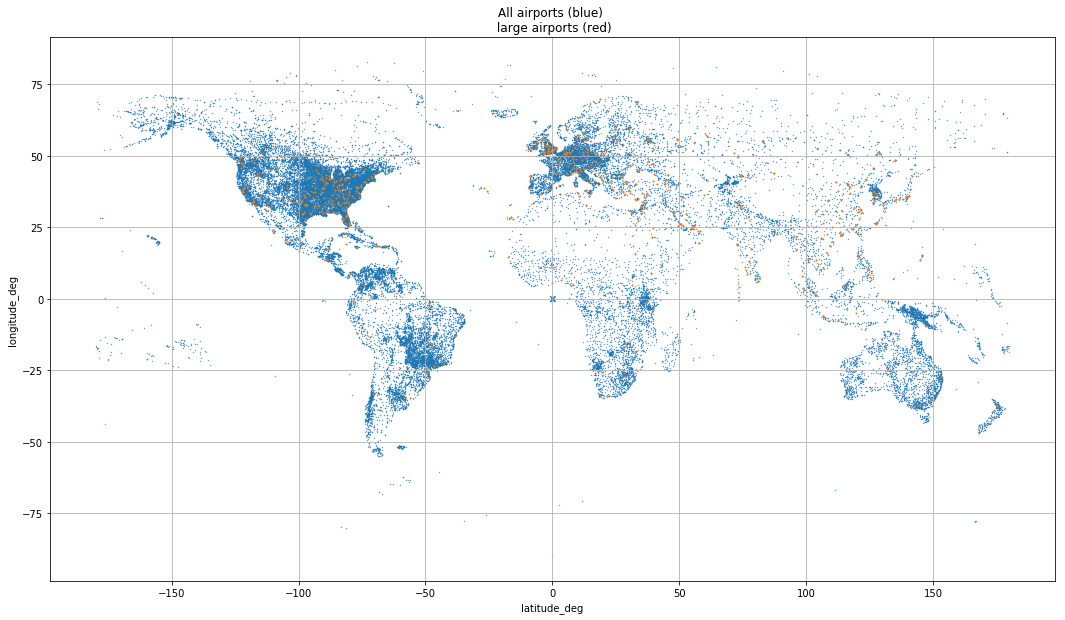

In [9]:
airports = pd.read_pickle(BASE_DIR + "part2/airports.pkl")
large_airports = pd.read_pickle(BASE_DIR +  "part2/large_airports.pkl")
routes = pd.read_pickle(BASE_DIR +  "part2/routes.pkl")
runways = pd.read_pickle(BASE_DIR +  "part2/runways.pkl")
pairs = pd.read_pickle(BASE_DIR +  "part2/pairs.pkl")

print("There are " + str(len(large_airports)) +
      " large airports in the world, let's focus on them")

# Code to plot all the airports
plt.figure(figsize=(18,10))
plt.scatter(airports["longitude_deg"], airports["latitude_deg"], s=.1)
plt.scatter(large_airports["longitude_deg"], large_airports["latitude_deg"], s=1)
plt.xlabel("latitude_deg")
plt.ylabel("longitude_deg")
plt.title("All airports (blue) \n large airports (red)")

print("airports columns:", airports.columns.values)
print("routes columns:", routes.columns.values)
print("runways columns:", runways.columns.values)
print("pairs columns:", pairs.columns.values)

You are provided with a dataframe of all pairs of large airports in the world: `pairs`

In [10]:
pairs.sample(5)

,ident_origin,ident_destination,iata_code_origin,iata_code_destination,haversine_distance,elevation_ft_origin,elevation_ft_destination,latitude_deg_origin,longitude_deg_origin,latitude_deg_destination,longitude_deg_destination
268644,TN-0002,CYYJ,NBE,YYJ,9548.523692,21.0,63.0,36.075833,10.438611,48.646900,-123.426003
45355,ENBR,CYVR,BGO,YVR,6988.905615,170.0,14.0,60.293400,5.218140,49.193901,-123.183998
117262,KLFT,KDSM,LFT,DSM,1268.633391,42.0,958.0,30.205299,-91.987602,41.534000,-93.663101
145523,KSBN,LFBD,SBN,BOD,6600.393557,799.0,162.0,41.708698,-86.317299,44.828300,-0.715556
181197,LICJ,OEMA,PMO,MED,2929.886681,65.0,2151.0,38.175999,13.091000,24.553400,39.705101


<div class="alert alert-info">
<h3><div class="label label-default">Question 11.1</div> <div class="label label-info"> Step 1</div></h3>
<br>
A first step towards the desanonymisation of the data is the following. Considering an <b> average speed of 700 km/h</b> you can compute the approximate distance between the airports in the anonymised data. Filter the possible pairs of airports by selecting airports that show a distance that is reasonably close to the distance you can compute with the anonymised data.</div>

In [54]:
# your code goes here ...
flight = flights2[0]

length = len(flight)/3600 
distance = length*700 


filtered_pairs = pairs[(pairs.haversine_distance >= distance*0.98) & (pairs.haversine_distance <= distance*1.02)]
print(filtered_pairs.shape)

filtered_pairs.head(5)

(1900, 11)


,ident_origin,ident_destination,iata_code_origin,iata_code_destination,haversine_distance,elevation_ft_origin,elevation_ft_destination,latitude_deg_origin,longitude_deg_origin,latitude_deg_destination,longitude_deg_destination
121,AMC,KAFW,PPE,AFW,1514.226674,71.0,722.0,31.351621,-113.305864,32.987598,-97.318802
125,AMC,KAUS,PPE,AUS,1498.103604,71.0,542.0,31.351621,-113.305864,30.194500,-97.669899
170,AMC,KEND,PPE,END,1523.390821,71.0,1307.0,31.351621,-113.305864,36.339199,-97.916496
176,AMC,KFTW,PPE,FTW,1509.430438,71.0,710.0,31.351621,-113.305864,32.819801,-97.362396
228,AMC,KOKC,PPE,OKC,1524.062548,71.0,1295.0,31.351621,-113.305864,35.393101,-97.600700


<div class="alert alert-success">
  <strong>Answer 11.1</strong>
  <p>Firstly we computed the distance of the first light in our dataset considering an average speed of 700km/h. Then we filtered our pairs selecting only the pairs with a haversine distance in the range [0.98*distance, 1.02*distance], and we found 1900 possible pairs.</p>
</div>

<div class="alert alert-info">
<h3><div class="label label-default">Question 11.2</div> <div class="label label-info">Step 2</div></h3>
<br>
You should now have a significantly smaller dataframe of possible pairs of airports. The next step is to eliminate the pairs of airports that are connected by commercial flights. You have all the existing commercial routes in the dataset <code>routes</code>. Use this dataframe to eliminate the airports that are not connected. How many pairs of airports possible do you have left?
</div>

```python
# This is template code cell, fill in the blanks, or use your own code
selected = pd.merge(...,
                    ...,
                    how=...,
                    left_on=[..., ...],
                    right_on=[..., ...])
```

In [55]:
selected = pd.merge(filtered_pairs,
                    routes,
                    how='inner',
                    left_on=['iata_code_origin', 'iata_code_destination'],
                    right_on=['SOURCE_AIRPORT', 'DESTINATION_AIRPORT'])

In [56]:
print(selected.shape)
selected.head()

(721, 14)


,ident_origin,ident_destination,iata_code_origin,iata_code_destination,haversine_distance,elevation_ft_origin,elevation_ft_destination,latitude_deg_origin,longitude_deg_origin,latitude_deg_destination,longitude_deg_destination,AIRLINE,SOURCE_AIRPORT,DESTINATION_AIRPORT
0,BIKF,ENBR,KEF,BGO,1489.455509,171.0,170.0,63.985001,-22.605600,60.293400,5.218140,DY,KEF,BGO
1,BIKF,ENBR,KEF,BGO,1489.455509,171.0,170.0,63.985001,-22.605600,60.293400,5.218140,FI,KEF,BGO
2,BKPR,EDDH,PRN,HAM,1474.359603,1789.0,53.0,42.572800,21.035801,53.630402,9.988230,4U,PRN,HAM
3,CYUL,KMSP,YUL,MSP,1524.665637,118.0,841.0,45.470600,-73.740799,44.882000,-93.221802,DL,YUL,MSP
4,CYUL,KMSP,YUL,MSP,1524.665637,118.0,841.0,45.470600,-73.740799,44.882000,-93.221802,WS,YUL,MSP


<div class="alert alert-success">
  <strong>Answer 11.2</strong>
  <p>After the merge operation we have 721 possible pairs.</p>
</div>

<div class="alert alert-info">
<h3><div class="label label-default">Question 11.3</div> <div class="label label-info"> Step 3</div></h3>
<br>
You now have a list of pairs of airports that are at a reasonable distance with respect to the distance between the airports in the anonymised data and that are connected by a commercial route. We have explored variables in the anonymised data that have not been altered and that may help us to narrow down the possibilities even more. Can you see what variable you may use? What previous question can help you a lot? Choose your criterion and use it to eliminate to pairs of airports that does not fit to the anonymised data.
</div>

<div class="alert alert-success">
  <strong>Answer 11.3</strong>
  <p>We think the best attribute we can use is ALT_STD_C, i.e., the barometric altitude. Now we will consider the difference between source airport altitude and destination airport altitude and then we will filter the pairs with a similar difference, using a 98% confidence interval.</p>
  
<p>However we can also think on a different approach, that is keeping a wider confidence level so that we can obtain more results, and then grouping by the results, so that we can have the more probable source and destination. Indeed, pairs dataframe contains duplicate couples src-dest iata airport because different airlines offer that flight.</p>
</div>

<div class="alert alert-info">
<h3><div class="label label-default">Question 11.4</div> <div class="label label-info">Step 4</div></h3>
<br>
Is there any other variables that can help discriminate more the airports?
</div>

In [58]:
diff_altitude = flight['ALT_STD_C'][0] - flight['ALT_STD_C'][-1]


filtered_pairs2 = selected[(selected.elevation_ft_origin-selected.elevation_ft_destination  >= 0.98*diff_altitude) & \
                           (selected.elevation_ft_origin-selected.elevation_ft_destination  <= 1.02*diff_altitude)]
                               
print(filtered_pairs2.shape)
filtered_pairs2.head(20)


(1, 14)


,ident_origin,ident_destination,iata_code_origin,iata_code_destination,haversine_distance,elevation_ft_origin,elevation_ft_destination,latitude_deg_origin,longitude_deg_origin,latitude_deg_destination,longitude_deg_destination,AIRLINE,SOURCE_AIRPORT,DESTINATION_AIRPORT
108,EGPH,LFML,EDI,MRS,1519.556404,135.0,74.0,55.950001,-3.3725,43.439272,5.221424,FR,EDI,MRS


<div class="alert alert-success">
  <strong>Answer 11.4</strong>
  <p>We can finally conclude that using a 98% confidence interval the first flight in flights2 is between Edinburgh and Marseille. </p>
  <p>Now let's try to use the second approach, i.e., keeping the confidence level wider and then grouping by iata code origin and iata code destination and choosing the more probable path. </p>
  
</div>

In [96]:
def find_src_dest(flight):
    length = len(flight)/3600 
    distance = length*700 
    filtered_pairs = pairs[(pairs.haversine_distance >= distance*0.9) & (pairs.haversine_distance <= distance*1.1)]
    selected = pd.merge(filtered_pairs,
                    routes,
                    how='inner',
                    left_on=['iata_code_origin', 'iata_code_destination'],
                    right_on=['SOURCE_AIRPORT', 'DESTINATION_AIRPORT'])
    diff_altitude = flight['ALT_STD_C'][0] - flight['ALT_STD_C'][-1]

    filtered_pairs2 = selected[(selected.elevation_ft_origin-selected.elevation_ft_destination  >= 0.9*diff_altitude) & \
                               (selected.elevation_ft_origin-selected.elevation_ft_destination  <= 1.1*diff_altitude)]

    print(filtered_pairs2.shape)
    return filtered_pairs2
    

In [97]:
possibilities = find_src_dest(flights2[0])
print(possibilities.groupby(['iata_code_origin','iata_code_destination']).size())

(46, 14)
iata_code_origin  iata_code_destination
BWN               SUB                      2
CDG               BEG                      2
CTS               ICN                      4
DLC               FOC                      1
EDI               MRS                      1
FRA               MLA                      2
HAK               NGB                      2
IAH               RSW                      1
KBP               FRA                      2
LGW               ALC                      6
                  ARN                      1
LHR               PMI                      2
MCO               PHL                      4
OSL               SVO                      2
POZ               DUB                      1
SHE               NRT                      4
TNA               SZX                      4
TPE               HAN                      3
TXL               PMO                      2
dtype: int64


<div class="alert alert-success">
  <strong>Conclusion</strong>
  <p>Using the second approach, the more probable path is London-Gatwick --> Alicante-Elche. </p>
 <p>We find this approach more reliable since we are very uncertain about the average speed of 700 km/h and the altitude measurements.</p> 
</div>